In [1]:
# How to validate ongoing learning?

# Here implemented method:
# - load current model
# - simulate a number of games with random moves initially to get random positions
# - played out deterministically based on current model
# - calculate mean difference between model values and what would be the MC-reward (discounted -1 / 1)
# - keep track of these errors for either only decisive games or all games

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v25
from Resources.Game import *


In [8]:
model = Model_v25()
model_saves = os.listdir('../Monte Carlo/Model Saves MC v25')
if len(model_saves) > 0:
    newest_model = max(int(i[6:-8]) for i in model_saves)
    latest_batch_index = newest_model
    model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC v25/model_{}_batches'.format(newest_model)))
criterion = nn.MSELoss()

n_games         = 200 # number of games per model load
n_random_moves  = 5 # number of random moves per player in the beginning
use_draws       = False
gamma           = 0.98 

draws = 0
white_wins = 0
black_wins = 0

In [9]:
val_mean_list = []
val_median_list = []
val_std_list = []

curr_ind = 0

validation_error_list = []

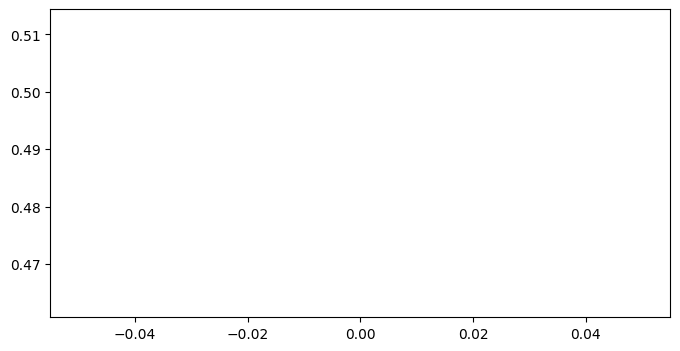

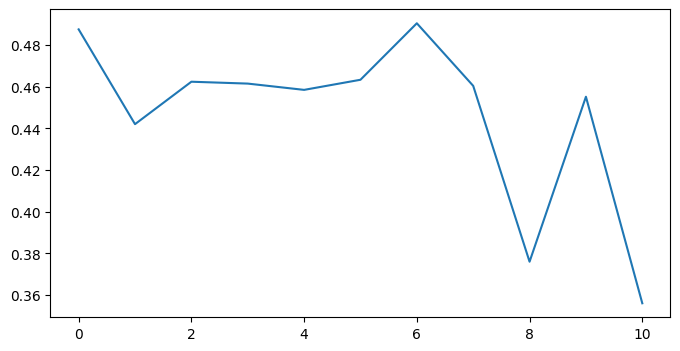

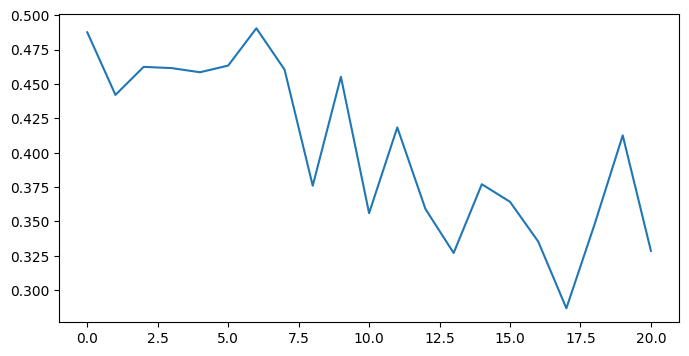

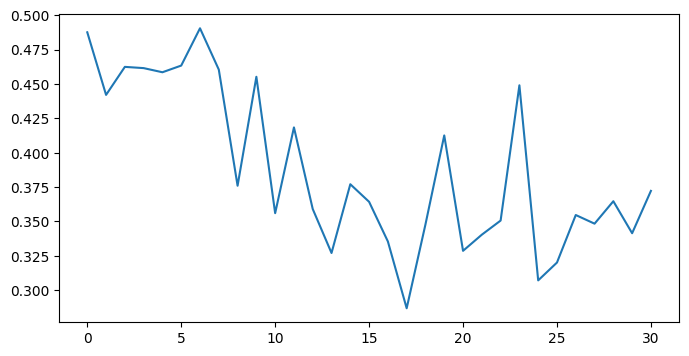

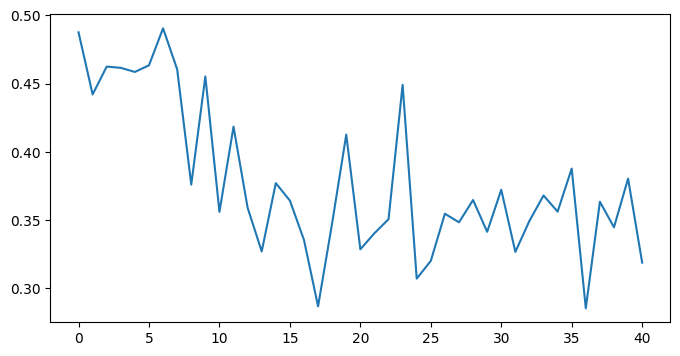

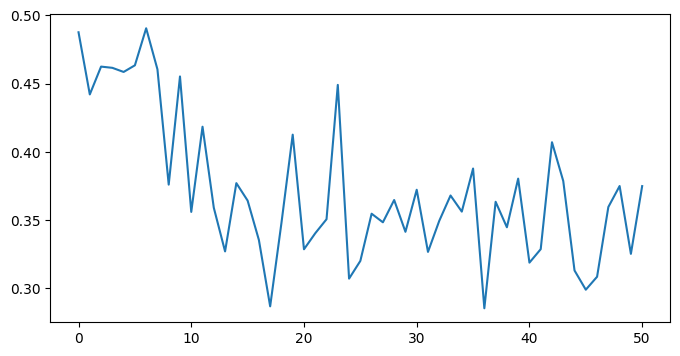

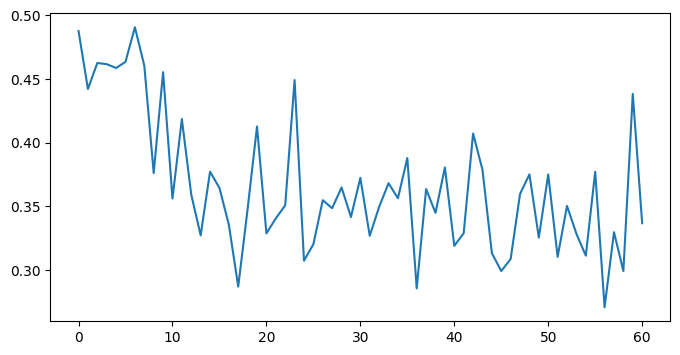

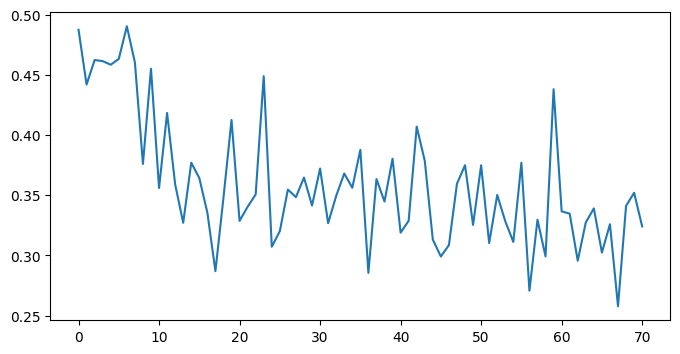

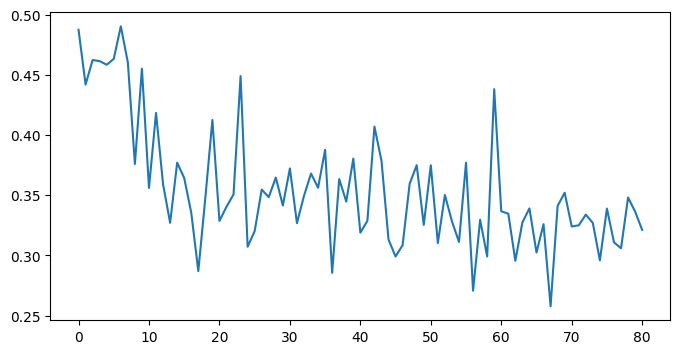

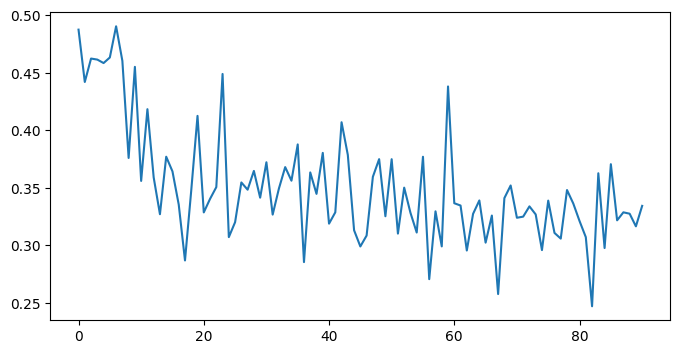

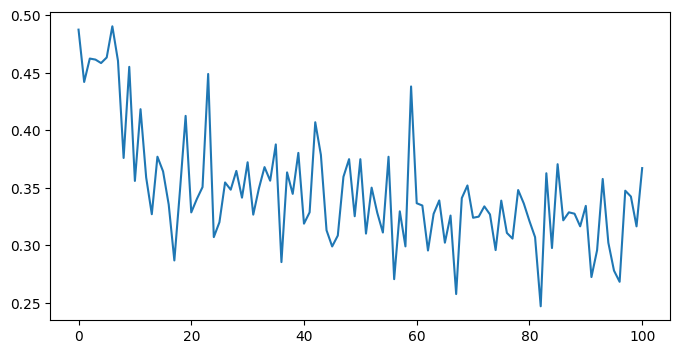

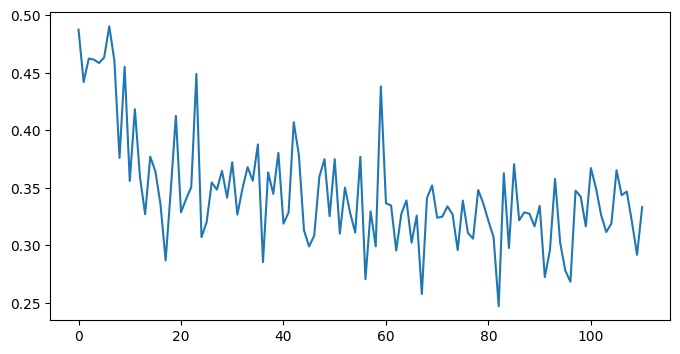

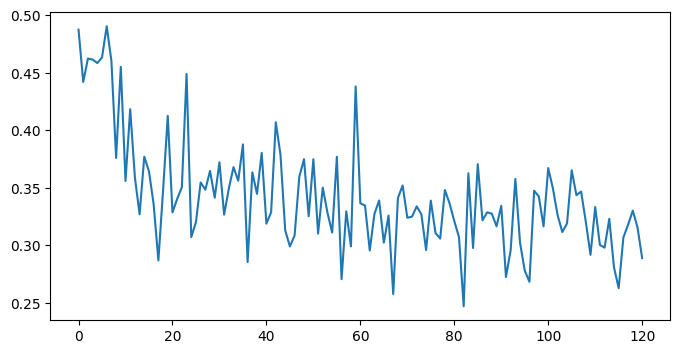

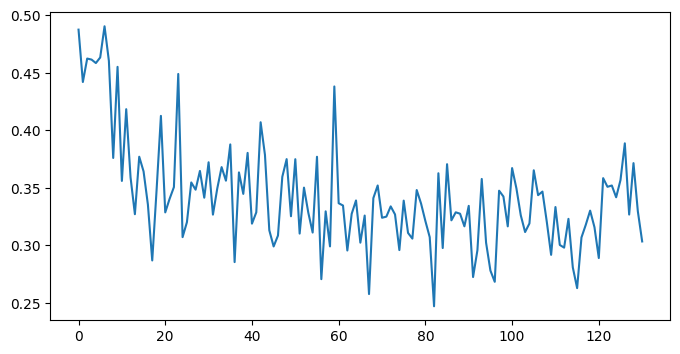

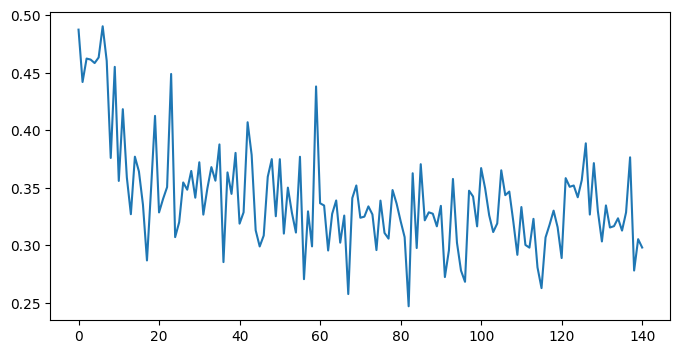

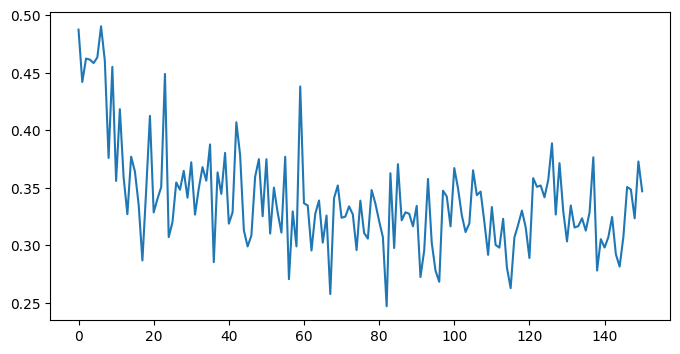

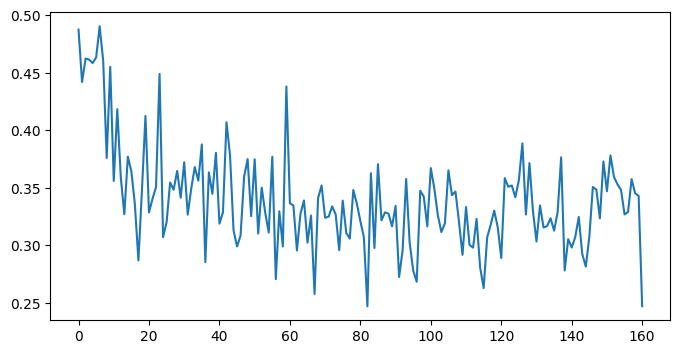

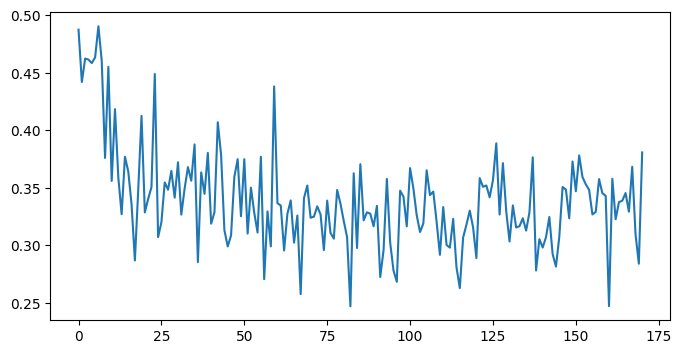

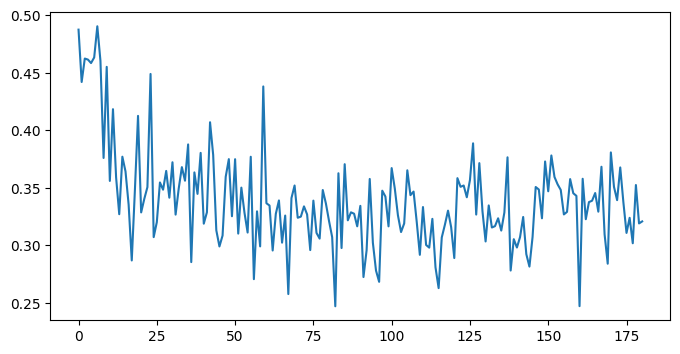

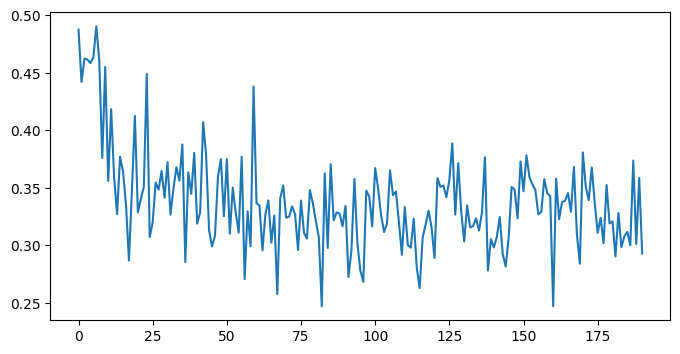

In [10]:
while True:

    # wait for new model
    while True:
        try:
            model_saves = os.listdir('../Monte Carlo/Model Saves MC v25')
            model_inds = [int(i[6:-8]) for i in model_saves]
            model_inds.sort()
        except:
            time.sleep(0.05)
            continue
        next_ind = curr_ind
        for ind in model_inds:
            if ind > curr_ind:
                next_ind = ind
                break
        if next_ind > curr_ind:
            break
        else:
            time.sleep(0.05)

    curr_ind = next_ind

    model = Model_v25()
    model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC v25/model_{}_batches'.format(curr_ind)))

    # validation_error_list = []

    meta_games = []
    meta_boards_white = []; meta_boards_black = []
    i = 0

    meta_active = []

    for game_ind in range(n_games):
        meta_games.append( Game() )
        meta_boards_white.append([]); meta_boards_black.append([])
        meta_active.append(True)

    model.eval()

    while True in meta_active:

        i += 1
        full_board_batch = []
        meta_board_batch_sizes = [] # save batch sizes to split model output afterwards
        meta_moves = []

        # go through games, collect positions for value evaluations
        for g, game in enumerate(meta_games):

            if not meta_active[g]:
                meta_board_batch_sizes.append(0)
                meta_moves.append([])
                continue

            meta_moves.append(game.PossibleMoves())
            game_ini = game.copy()
            board_batch = []
            mate = False

            for move in meta_moves[-1]:
                game.PlayMove(move)
                board_batch.append(board_to_tensor(game.pieces))
                game.FlipBoard()
                if game.is_over():
                    mate = True
                    break
                game = game_ini.copy()

            meta_games[g] = game.copy()

            if mate:
                meta_active[g] = False
                meta_board_batch_sizes.append(0)
                game.FlipBoard()
                if i % 2 == 1:
                    meta_boards_white[g].append(board_to_bool_tensor(game.pieces))
                if i % 2 == 0:
                    meta_boards_black[g].append(board_to_bool_tensor(game.pieces))

            if not mate:
                full_board_batch = full_board_batch + board_batch
                meta_board_batch_sizes.append(len(board_batch))

        if len(full_board_batch) == 0:
            break

        # get values of all positions
        full_board_batch = torch.stack(full_board_batch)
        out = model(full_board_batch).detach()
        meta_values = torch.split(out, meta_board_batch_sizes)

        # make moves for all games
        for g, game in enumerate(meta_games):

            if not meta_active[g]:
                continue

            if i <= n_random_moves * 2:
                chosen_ind = np.random.choice(range(len(meta_moves[g])))
                chosen_move = meta_moves[g][chosen_ind]

            else:
                values = meta_values[g]
                max_ind = torch.argmax(values).item()
                chosen_move = meta_moves[g][max_ind]

            game.PlayMove(chosen_move)
            if i % 2 == 1:
                meta_boards_white[g].append(board_to_bool_tensor(game.pieces))
            if i % 2 == 0:
                meta_boards_black[g].append(board_to_bool_tensor(game.pieces))
            game.FlipBoard()

    meta_inputs = []
    meta_labels = []

    for g, game in enumerate(meta_games):
        
        winner = game.get_winner()
        if winner == 'draw':
            draws += 1
            continue
            reward_white = 0;   reward_black = 0

        elif winner == 'white':
            white_wins += 1
            reward_white = 1;   reward_black = -1

        elif winner == 'black':
            black_wins += 1
            reward_white = -1;  reward_black = 1

        labels_white = [reward_white * gamma**(len(meta_boards_white[g]) - 1 - i) for i in range(len(meta_boards_white[g]))]
        labels_black = [reward_black * gamma**(len(meta_boards_black[g]) - 1 - i) for i in range(len(meta_boards_black[g]))]

        meta_inputs = meta_inputs + meta_boards_white[g] + meta_boards_black[g]
        meta_labels = meta_labels + labels_white + labels_black

    inputs_tens = torch.stack(meta_inputs)
    labels_tens = torch.Tensor(meta_labels)

    values_tens = model(inputs_tens).detach()

    validation_error = criterion(labels_tens.flatten(), values_tens.flatten())
    validation_error_list.append(validation_error)

    # print('validation error for model_batch {}: '.format(model_ind))
    # print('mean = {}, median = {}, std = {}'.format(round(np.mean(validation_error_list), 2), round(np.median(validation_error_list), 2), round(np.std(validation_error_list), 2)))

    if  len(validation_error_list) % 10 == 1:
        plt.figure(figsize=(8, 4))
        plt.plot(validation_error_list)
        plt.show()
        

In [24]:
print(validation_error_list)

[tensor(0.3129)]


(0.0, 150.0)

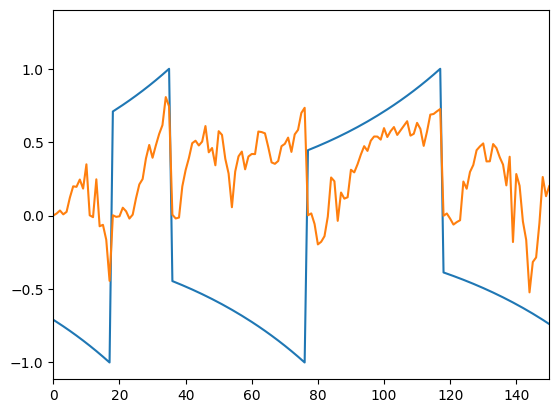

In [14]:
plt.plot(labels_tens)
plt.plot(values_tens)
plt.xlim([0, 150])

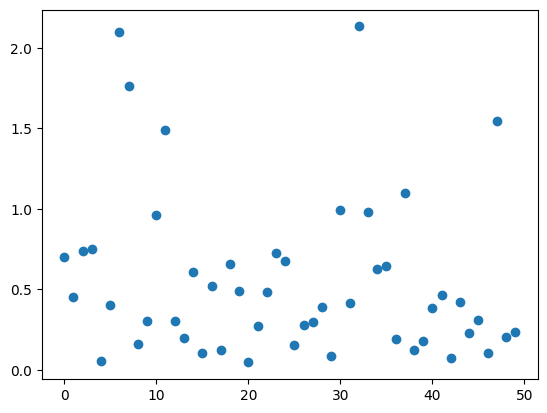

In [51]:
plt.scatter(range(len(validation_error_list)), validation_error_list)
plt.show()

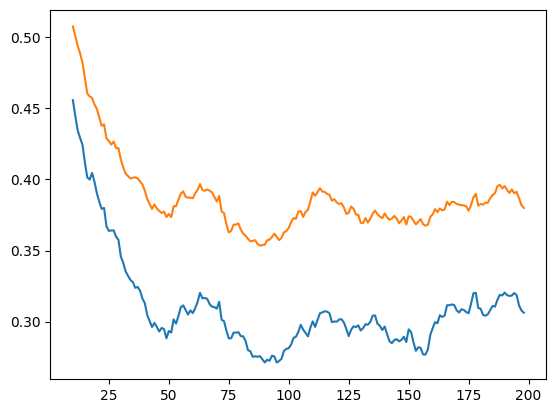

In [40]:
av_window = 20
plt.plot(range(av_window//2, len(val_median_list) - av_window//2), [np.nanmean(val_median_list[i:(i+av_window)]) for i in range(len(val_median_list) - av_window)], label='median')
plt.plot(range(av_window//2, len(val_mean_list) - av_window//2), [np.nanmean(val_mean_list[i:(i+av_window)]) for i in range(len(val_mean_list) - av_window)], label='mean')
        
plt.show()